In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from utils import *
from deconv import *

In [2]:
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

## Example Bipolar Data (2021_05_12 v2)
### In each table:                                                             
- All 200um static spot stimuli.
- DD and PD CSVs are organized as pairs of trials (just two each) for each ROI.
- e.g. roi0_t0 | roi0_t1 | ... | roiN_t1
- (original name: DD_20210512_scan6_200um.csv)

### Specs
- **ROI Size:** 10um
- **Scan rate for all:** 58.25 Hz

In [12]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_05_12_v2/waveforms/")
n_trials = 2
hz = 58.25
dt = 1 / hz

recs = {}
for d in ["DD", "PD"]:
    vals = pd.read_csv(os.path.join(data_path, d) + ".csv", skiprows=1).values.T
    recs[d] = vals.reshape(vals.shape[0] // n_trials, n_trials, -1)

normed = {d: rs / np.max(rs, axis=2, keepdims=True) for d, rs in recs.items()}
avg_recs = {d: np.mean(rs, axis=1) for d, rs in recs.items()}
avg_normed = {d: rs / np.max(rs, axis=1, keepdims=True) for d, rs in avg_recs.items()}

aligned_recs = {d: aligned_avg(rs) for d, rs in avg_recs.items()}
aligned_normed = {d: rs / np.max(rs) for d, rs in aligned_recs.items()}


_, _, n_pts = recs["DD"].shape # number of points is the same across fields
rec_xaxis = np.arange(n_pts) * dt
print("DD Shape (n_rois, n_trials, n_pts):", recs["DD"].shape)
print("PD Shape (n_rois, n_trials, n_pts):", recs["PD"].shape)

DD Shape (n_rois, n_trials, n_pts): (9, 2, 449)
PD Shape (n_rois, n_trials, n_pts): (7, 2, 449)


### Data Overview (plots of all ROIs for both scan-fields)

<IPython.core.display.Javascript object>


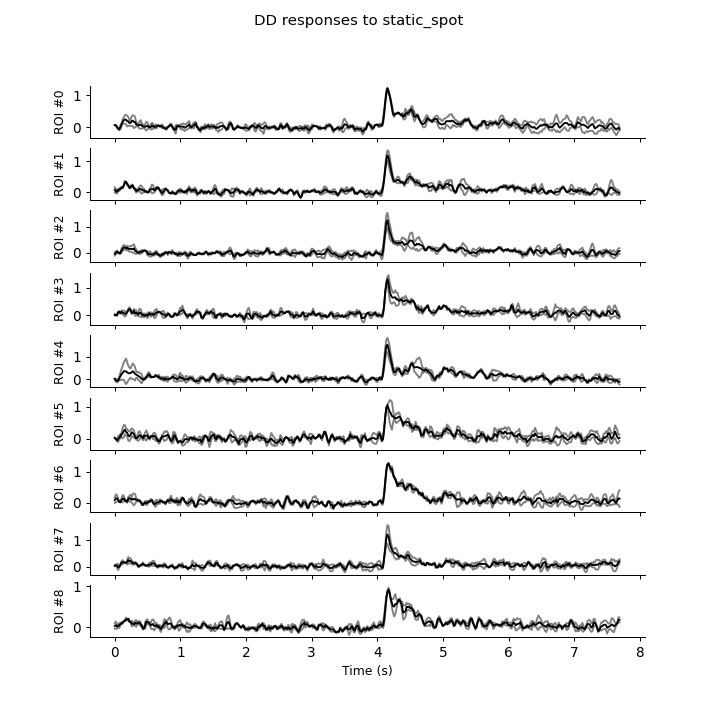

<IPython.core.display.Javascript object>


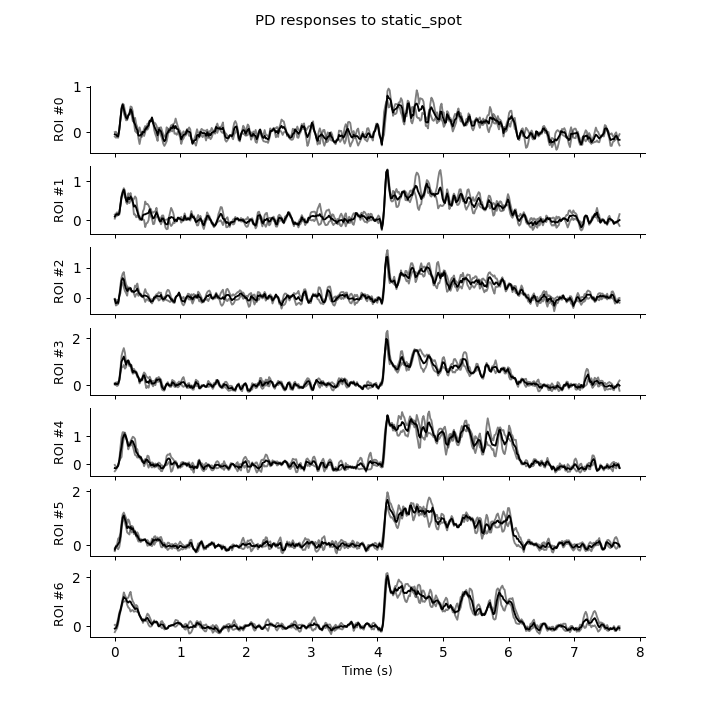

In [21]:
rec_figures = {}
for depth, rois in recs.items():
    rec_figures[depth] = {}
    rec_figures[depth]["fig"], rec_figures[depth]["ax"] = plt.subplots(
        len(rois), sharex=True, figsize=(8, 8)
    )
    for i, trials in enumerate(rois):
        for tr in trials:
            rec_figures[depth]["ax"][i].plot(rec_xaxis, tr, c="black", alpha=0.5)

        av = np.mean(trials, axis=0)
        rec_figures[depth]["ax"][i].plot(rec_xaxis, av, c="black")
        rec_figures[depth]["ax"][i].set_ylabel("ROI #%i" % i)
        clean_axes(rec_figures[depth]["ax"][i])

        rec_figures[depth]["fig"].suptitle("%s responses to static_spot" % depth)
        rec_figures[depth]["ax"][-1].set_xlabel("Time (s)")
        rec_figures[depth]["fig"].show()

<IPython.core.display.Javascript object>


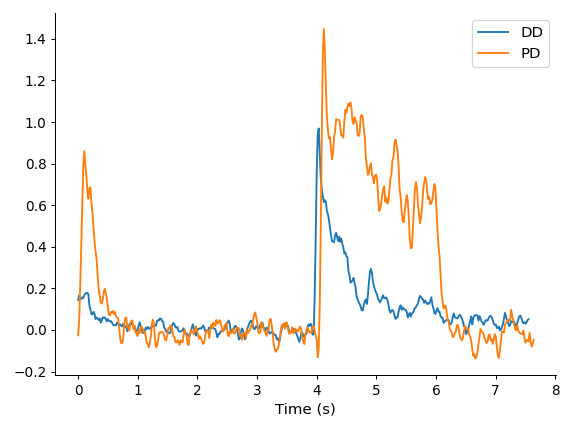

In [18]:
aligned_fig, aligned_ax = plt.subplots(1)
for depth, avg in aligned_recs.items():
    aligned_ax.plot(np.arange(len(avg)) * dt, avg, label=depth)

clean_axes(aligned_ax)
aligned_ax.set_xlabel("Time (s)", fontsize=12)
aligned_ax.legend(fontsize=12)
aligned_fig.tight_layout()
aligned_fig.show()

### QSE estimation from static spot responses in the proximal scan field
- steady state QSEs calculated with the relatively flat section of the responses (with the exception of the moving spot which has no such region
- base QSEs calculated from a stable window of the baseline preceding the response

In [22]:
windows = {"base": {0: 1.5, 1: 3.5}, "steady": {0: 5., 1: 6.}}

qses, avg_qses = [{"steady": [], "base": []} for _ in range(2)]
steady_start = nearest_index(rec_xaxis, windows["steady"][0])
steady_stop = nearest_index(rec_xaxis, windows["steady"][1])
base_start = nearest_index(rec_xaxis, windows["base"][0])
base_stop = nearest_index(rec_xaxis, windows["base"][1])

for trials in recs["PD"]:
    for tr in trials:
        qses["steady"].append(quantal_size_estimate(tr[steady_start:steady_stop]))
        qses["base"].append(quantal_size_estimate(tr[base_start:base_stop]))
    
    av = np.mean(trials, axis=0)
    avg_qses["steady"].append(quantal_size_estimate(av[steady_start:steady_stop]))
    avg_qses["base"].append(quantal_size_estimate(av[base_start:base_stop]))
    
print("Quantal Size Estimates for static spot:")
for k in windows.keys():
    qses[k] = np.array(qses[k])
    avg_qses[k] = np.array(avg_qses[k])
    print("  period:", k)
    print("    per-trial:", np.round(qses[k], decimals=3)) 
    print("      mean: %.3f" % np.mean(qses[k]))
    print("    averaged trials:", np.round(avg_qses[k], decimals=3))
    print("      mean: %.3f" % np.mean(avg_qses[k]))
    print("")

Quantal Size Estimates for static spot:
  period: base
    per-trial: [ -2.294  -0.67    2.232 -14.533  -4.539   1.978   2.106  -2.728  -2.629
  -0.786   5.409  -1.832  -2.185  -0.493]
      mean: -1.497
    averaged trials: [-0.689  2.124  2.86  38.412 -0.56  -2.299 -0.33 ]
      mean: 5.645

  period: steady
    per-trial: [0.103 0.12  0.072 0.136 0.13  0.086 0.153 0.121 0.212 0.201 0.106 0.102
 0.325 0.218]
      mean: 0.149
    averaged trials: [0.061 0.052 0.051 0.084 0.109 0.05  0.179]
      mean: 0.084



### Generate representative biexponential quantal event
Rough representation of an iGluSnFr mini from a bipolar terminal

using qse = 0.14890


<IPython.core.display.Javascript object>


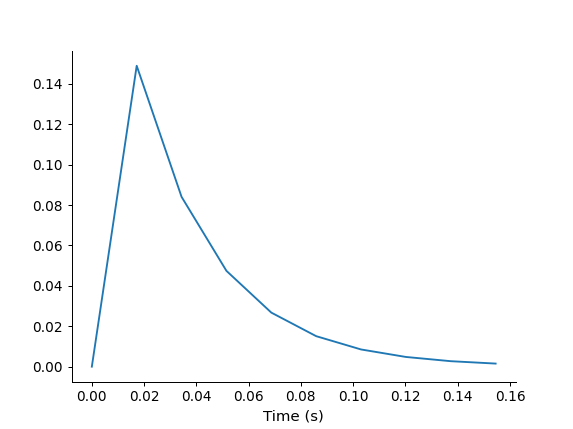

In [25]:
tau1 = 2 # rise [ms]
tau2 = 30  # decay [ms]
quantum_pts = 10

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_quantum = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

qse = np.mean(qses["steady"])
qse_quantum = biexp_quantum * qse
print("using qse = %.5f" % qse)

biexp_fig, biexp_ax = plt.subplots(1)
biexp_ax.plot(biexp_xaxis, qse_quantum)
biexp_ax.set_xlabel("Time (s)", fontsize=12)
clean_axes(biexp_ax)
biexp_fig.savefig(os.path.join(data_path, "qse_quantum.svg"), bbox_inches="tight")
biexp_fig.show()

### Run through quantal analysis with example waveform

In [26]:
depth = "PD"
roi_idx = 0
trial_idx = 0
ev = normed[depth][roi_idx, trial_idx]
quantum_fft = np.fft.rfft(qse_quantum, n=len(ev))
rec_fft = np.fft.rfft(ev)
inv = np.fft.irfft(rec_fft / quantum_fft)
deconv = np.convolve(inv, qse_quantum)

bin_t = 0.05  # st
# bin_t = dt  # s
sz = int(bin_t / dt)
bin_edges = np.arange(sz, len(inv) + sz, sz) * dt
binned = bin_mean(inv, sz)
print("points per bin:", sz)
print("time per bin: %.2fms" % (sz * dt * 1000))

scale_mode = False
ceiling = 0.95
max_q = 5
q_scale = 1. / max_q if scale_mode else 1.

quanta = raster(binned, thresh=np.max(binned) * ceiling / max_q, max_q=max_q)    
quantal_sum = sum_quanta(quanta, bin_edges, qse_quantum * q_scale, dt)
quantal_sum_xaxis = np.arange(len(quantal_sum)) * dt

points per bin: 2
time per bin: 34.33ms


<IPython.core.display.Javascript object>


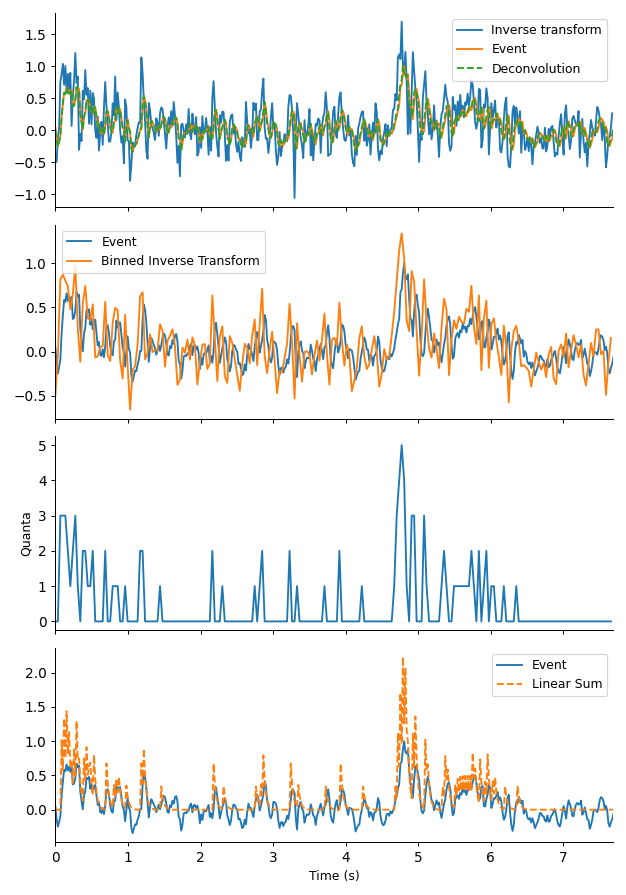

In [9]:
ex_quanta_fig, ex_quanta_ax = plt.subplots(4, sharex=True,figsize=(7, 10))

ex_quanta_ax[0].plot(rec_xaxis[:-1], inv, label="Inverse transform")
ex_quanta_ax[0].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[0].plot(np.arange(len(deconv)) * dt, deconv, label="Deconvolution", linestyle="--")
ex_quanta_ax[0].legend()

ex_quanta_ax[1].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[1].plot(bin_edges, binned, label="Binned Inverse Transform")
ex_quanta_ax[1].legend()

ex_quanta_ax[2].plot(bin_edges, quanta)
ex_quanta_ax[2].set_ylabel("Quanta")

ex_quanta_ax[3].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[3].plot(quantal_sum_xaxis, quantal_sum, label="Linear Sum", linestyle="--")
ex_quanta_ax[3].set_xlim(0, np.max(rec_xaxis))
ex_quanta_ax[3].legend()
ex_quanta_ax[3].set_xlabel("Time (s)")

for ax in ex_quanta_ax:
    clean_axes(ax)

ex_quanta_fig.tight_layout()
ex_quanta_fig.show()

### Run quantal analysis on all recordings
- All trials, of all ROIs, from both proximal and distal scan fields
- Run through with a range of maximum quanta count (`max_q`) values

In [27]:
def quantify(data, bin_t=0.05, ceiling=0.95, max_q=5, scale_mode=False):
    res = {}
    for depth, rois in data.items():
        res[depth] = {}
        (
            res[depth]["quanta"], 
            res[depth]["quanta_xaxis"], 
            res[depth]["quantal_sum"],
            res[depth]["quantal_sum_xaxis"],
        ) = get_quanta(
                rois, 
                qse_quantum, 
                dt, 
                bin_t=bin_t,
                ceiling=ceiling,
                max_q=max_q,
                scale_mode=scale_mode
            )
    return res

quantifications = {i: quantify(recs, max_q=i, scale_mode=False) for i in range(1, 15)}
aligned_quants = {i: quantify(aligned_recs, max_q=i, scale_mode=False) for i in range(1, 15)}

### Calculate Mean Squared Error to see how the quantal sums fit to the original data depends on the maximum number of quanta per time bin

<IPython.core.display.Javascript object>


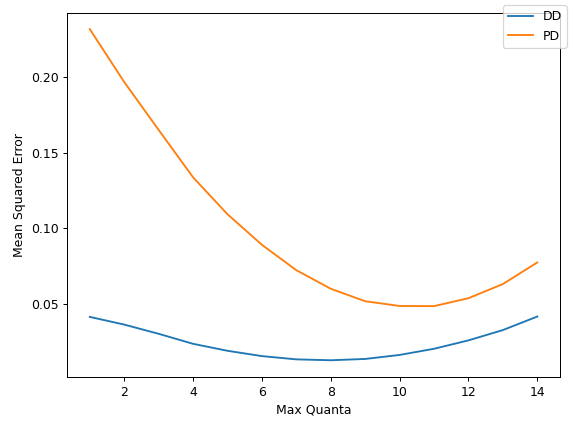

In [34]:
mses = {d: [] for d in ["DD", "PD"]}
for n, data in quantifications.items():
    for depth, quants in data.items():
        r = recs[depth]
        diff = r - quants["quantal_sum"][:, :, :r.shape[-1]]  # truncate to same shape
        mses[depth].append(np.mean(diff ** 2))

mse_xaxis = np.array(list(quantifications.keys()))
mses = {d: np.array(rois) for d, rois in mses.items()}

mse_fig, mse_ax = plt.subplots(1)
for i, (depth, errors) in enumerate(mses.items()):
    mse_ax.plot(mse_xaxis, errors, label=depth)
    
mse_ax.set_ylabel("Mean Squared Error")
mse_ax.set_xlabel("Max Quanta")
clean_axes(ax)
mse_fig.legend()
mse_fig.tight_layout()
mse_fig.show()

<IPython.core.display.Javascript object>


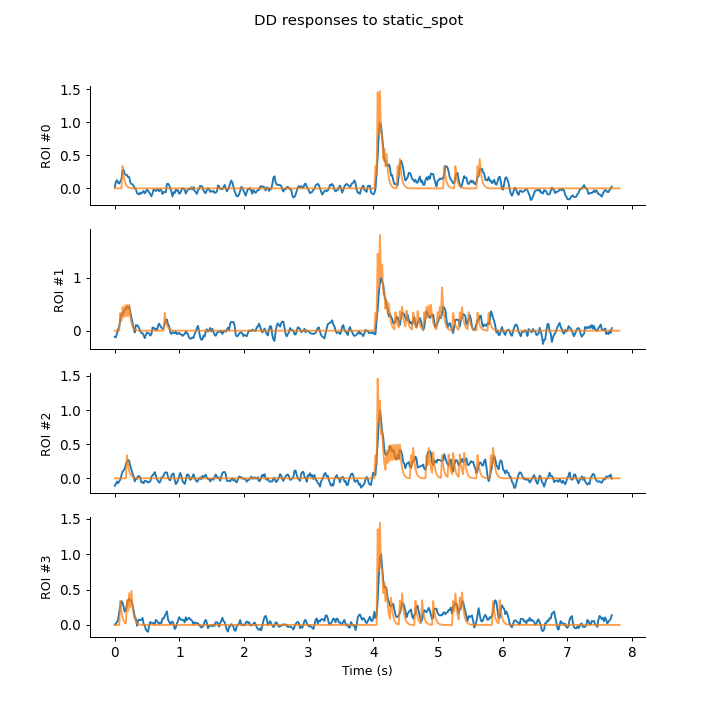

<IPython.core.display.Javascript object>


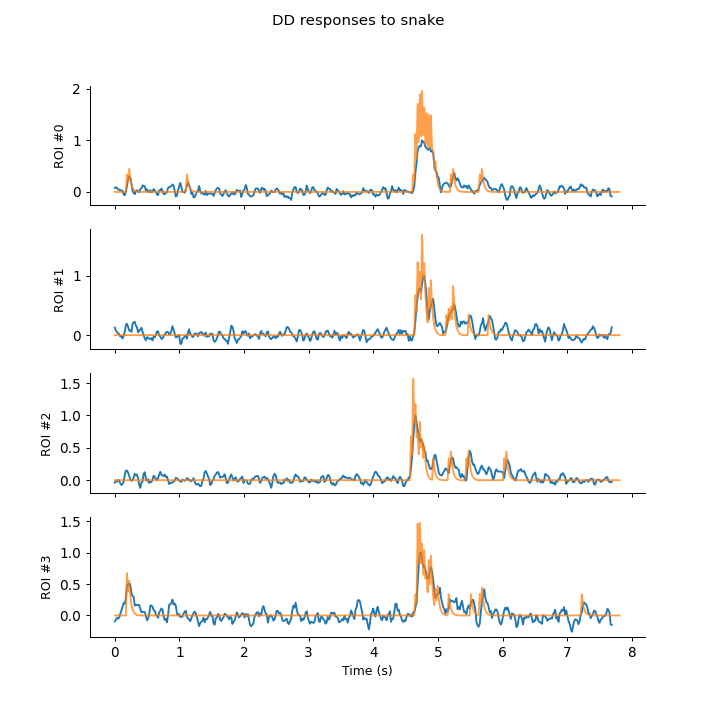

<IPython.core.display.Javascript object>


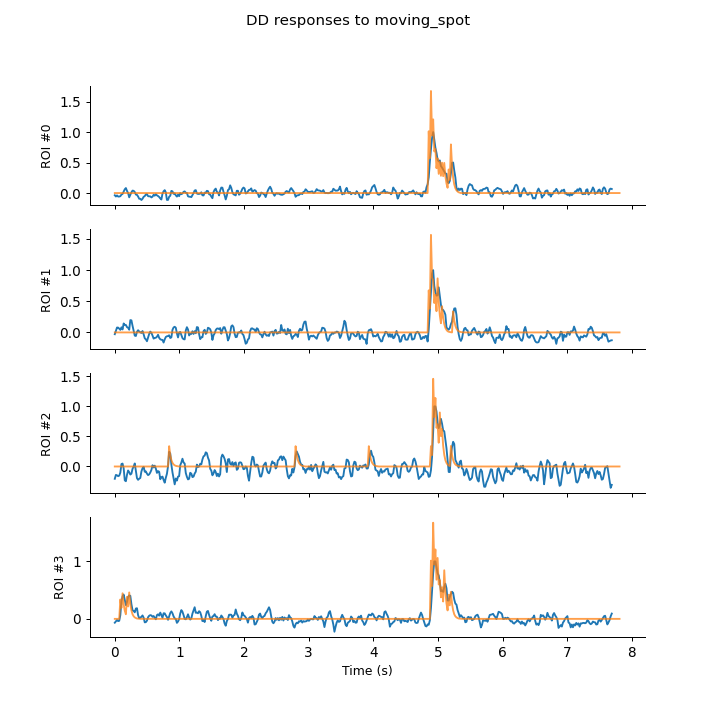

<IPython.core.display.Javascript object>


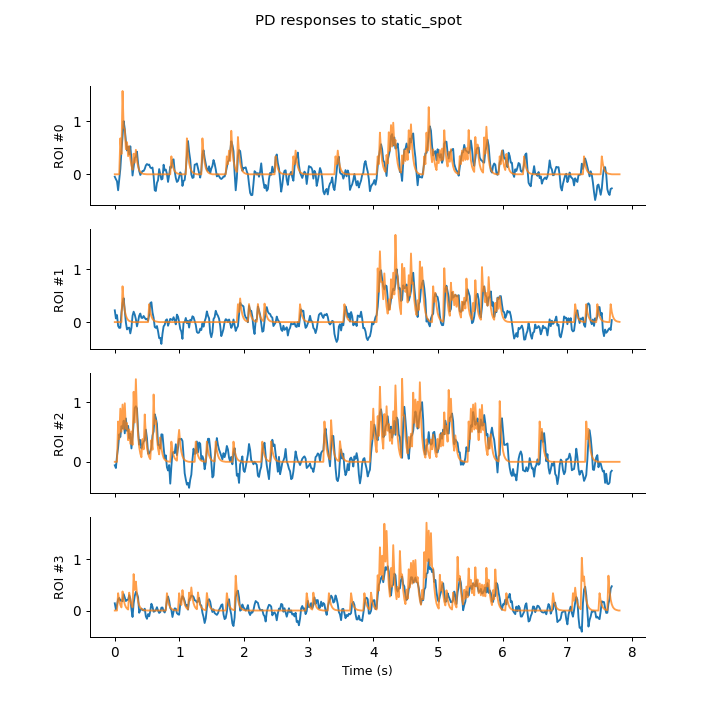

<IPython.core.display.Javascript object>


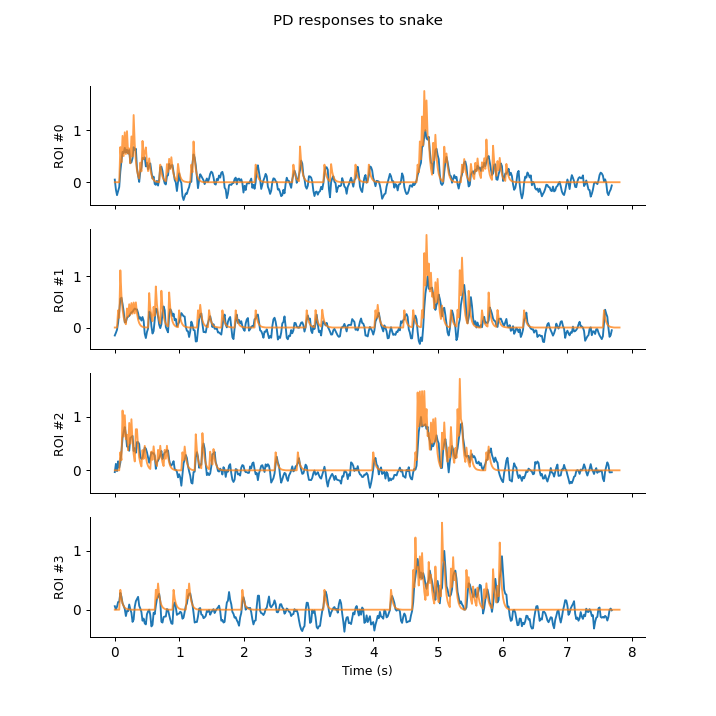

<IPython.core.display.Javascript object>


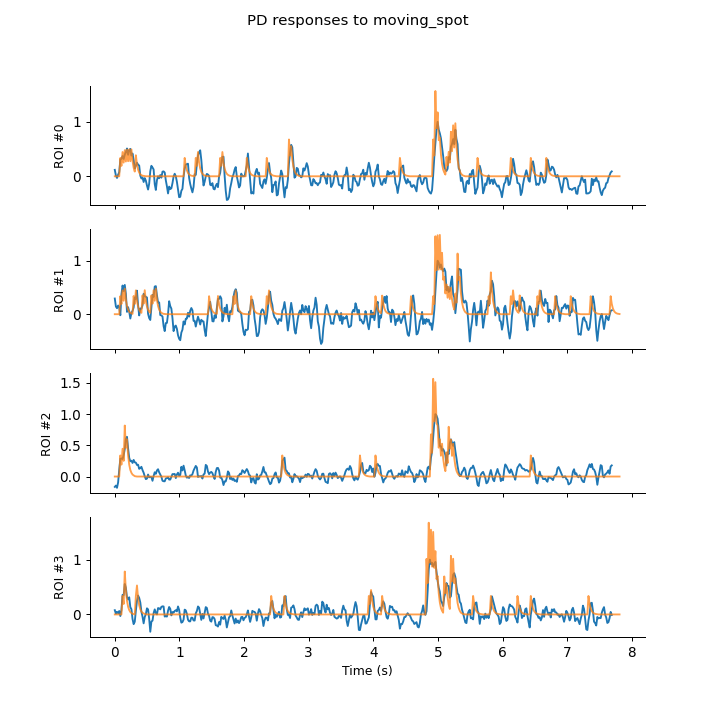

In [12]:
max_q = 4
trial_idx = 0
quants = quantifications[max_q]

quanta_figures = {}
for depth, stims in normed.items():
    quanta_figures[depth] = {}
    for stim, rois in stims.items():
        quanta_figures[stim] = {}
        quanta_figures[stim]["fig"], quanta_figures[stim]["ax"] = plt.subplots(
            n_rois, sharex=True, figsize=(8, 8)
        )
        roi = np.mean(rois, axis=1) if trial_idx is None else rois[:, trial_idx]
        for i, tr in enumerate(roi):
            quanta_figures[stim]["ax"][i].plot(
                rec_xaxis, tr, label="Event" if not i else None)
            qsum = (np.mean(quants[depth][stim]["quantal_sum"][i], axis=0)
                    if trial_idx is None
                    else quants[depth][stim]["quantal_sum"][i, trial_idx])
            quanta_figures[stim]["ax"][i].plot(
                quants[depth][stim]["quantal_sum_xaxis"], 
                qsum, 
                alpha=0.75, 
                label="Quantal Sum" if not i else None
            )
            quanta_figures[stim]["ax"][i].set_ylabel("ROI #%i" % i)
            clean_axes(quanta_figures[stim]["ax"][i])

        quanta_figures[stim]["fig"].suptitle("%s responses to %s" % (depth, stim))
        quanta_figures[stim]["ax"][-1].set_xlabel("Time (s)")
        quanta_figures[stim]["fig"].show()

<IPython.core.display.Javascript object>


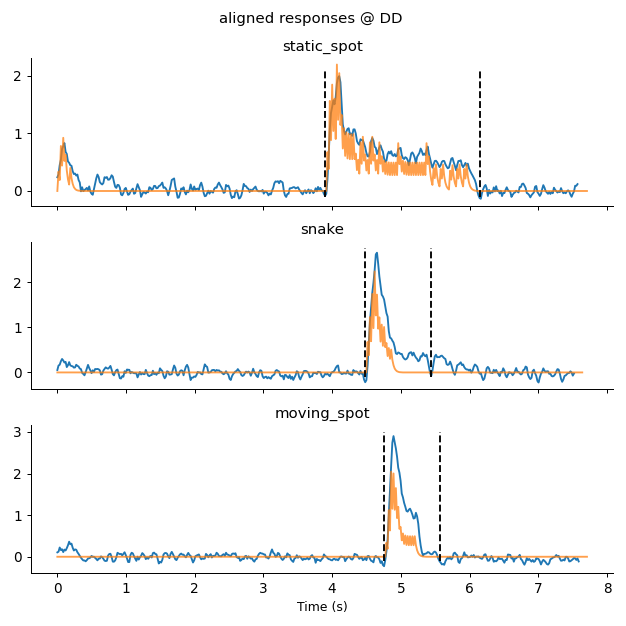

<IPython.core.display.Javascript object>


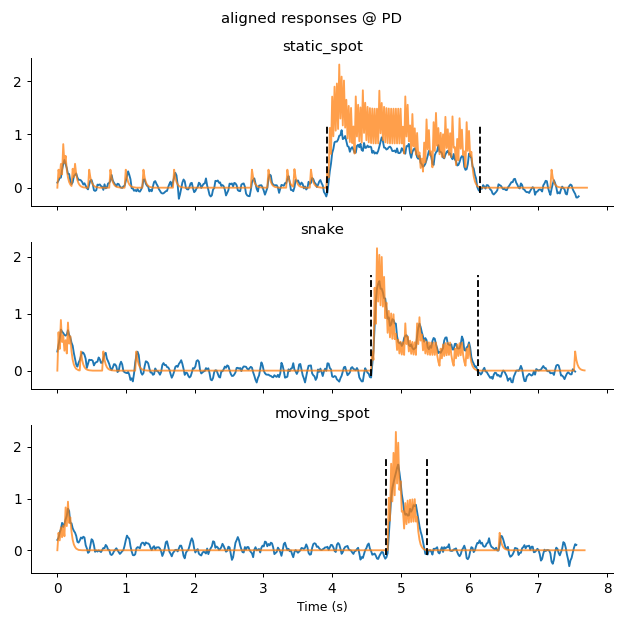

In [13]:
max_q = 5
aligned_qs = aligned_quants[max_q]
mark_ends = True
mark_peak = True

aligned_q_figs = {}
for depth, stims in aligned_qs.items():
    aligned_q_figs[depth] = {}
    aligned_q_figs[depth]["fig"], aligned_q_figs[depth]["ax"] = plt.subplots(
        len(stim_labels), sharex=True, figsize=(7, 7)
    )
    for (stim, qs), ax in zip(stims.items(), aligned_q_figs[depth]["ax"]):
        avg = aligned_recs[depth][stim]
        ax.plot(np.arange(len(avg)) * dt, avg)
        ax.plot(qs["quantal_sum_xaxis"], qs["quantal_sum"], alpha=0.75)
        if mark_ends:
            rise_idx = find_rise_bsln(avg, bsln_start=100, bsln_end=150, step=2)
            rise_t = rise_idx * dt
            ax.plot([rise_t, rise_t], [-0.1, np.max(avg) + 0.1], linestyle="--", c="black")
            fall_idx = find_bsln_return(avg, bsln_start=100, bsln_end=150, offset=-0.01, step=5)
            fall_t = fall_idx * dt
            ax.plot([fall_t, fall_t], [-0.1, np.max(avg) + 0.1], linestyle="--", c="black")
        ax.set_title(stim)
        clean_axes(ax)
        
    aligned_q_figs[depth]["fig"].suptitle("aligned responses @ %s " % depth)
    aligned_q_figs[depth]["ax"][-1].set_xlabel("Time (s)")
    aligned_q_figs[depth]["fig"].tight_layout()
    aligned_q_figs[depth]["fig"].show()

In [14]:
q_counts = quants["PD"]["snake"]["quanta"]
q_xaxis = quants["PD"]["snake"]["quanta_xaxis"]

In [16]:
delta = 0.1
duration = 10
n = int(duration / delta)
x = np.arange(n) * delta
pq = poisson_quanta(5, delta, duration)
qts = quanta_to_times(pq, delta)
requantize = times_to_quanta(qts, delta, duration)
bi_pq = poisson_bipolar(20, 1, 5, 5, 0.01)
print("total quanta:", np.sum(pq))

total quanta: 51


<IPython.core.display.Javascript object>


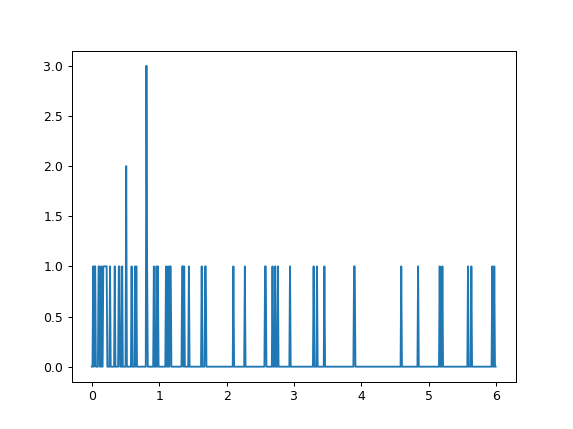

In [17]:
fff, aaa = plt.subplots(1)
aaa.plot(np.arange(len(bi_pq)) * 0.01, bi_pq)

<IPython.core.display.Javascript object>


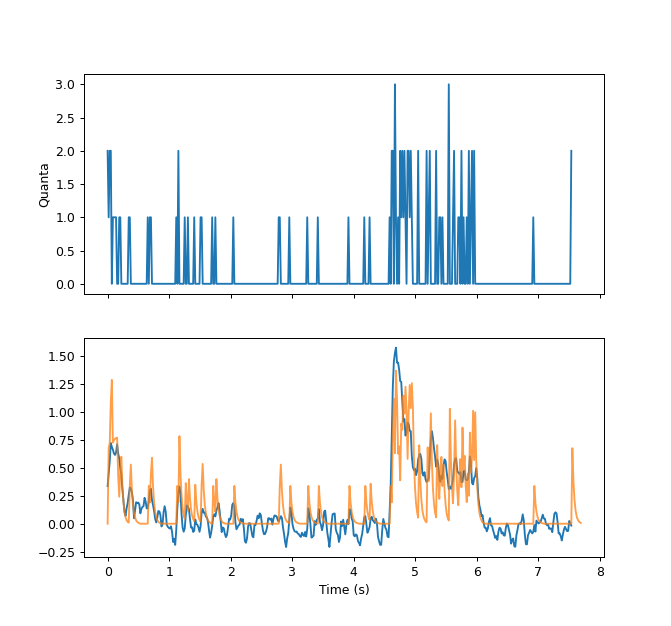

In [18]:
depth = "PD"
stim = "snake"
roi_idx = None
ex = aligned_recs[depth][stim] if roi_idx is None else avg_recs[depth][stim][roi_idx]
avg_inv = np.fft.irfft(
    np.fft.rfft(ex) / np.fft.rfft(qse_quantum, n=len(ex))
)

rpq = poisson_of_release(avg_inv)
rpq_sum = sum_quanta(rpq, np.arange(len(rpq)) * dt, qse_quantum, dt)
rpq_sum_xaxis = np.arange(len(rpq_sum)) * dt

rate_poisson_fig, rate_poisson_ax = plt.subplots(2, sharex=True, figsize=(7.5, 7))
rate_poisson_ax[0].plot(np.arange(len(rpq)) * dt, rpq)
rate_poisson_ax[0].set_ylabel("Quanta")
rate_poisson_ax[1].plot(np.arange(len(ex)) * dt, ex)
rate_poisson_ax[1].plot(rpq_sum_xaxis, rpq_sum, alpha=0.75)
rate_poisson_ax[1].set_xlabel("Time (s)")
rate_poisson_fig.show()

In [19]:
aligned_rates = {
    d: {
        s: np.fft.irfft(np.fft.rfft(r) / np.fft.rfft(qse_quantum, n=len(r)))
        for s, r in stims.items()
    }
    for d, stims in aligned_recs.items()
}

# TODO: clip using the length of the PD responses?
# TODO: clip using the savgol of the rate?
extra_lead = 0
extra_tail = 5
clipped_aligned_rates = {
    d: {
        s: r[
            find_rise_bsln(r, bsln_start=100, bsln_end=150, step=1) - extra_lead:
            find_bsln_return(
                r, bsln_start=100, bsln_end=150, offset=-0.1, step=5) + extra_tail
        ]
        for s, r in stims.items()
    }
    for d, stims in aligned_rates.items()
}

<IPython.core.display.Javascript object>


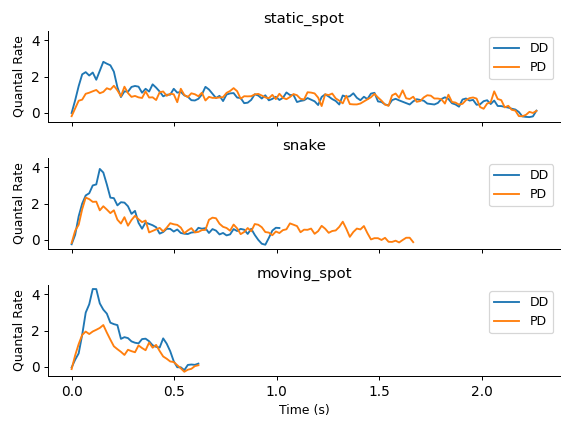

In [20]:
clipped_rate_fig, clipped_rate_ax = plt.subplots(len(stim_labels), sharex=True, sharey=True)
for depth, stims in clipped_aligned_rates.items():
    for ax, (stim, rate) in zip(clipped_rate_ax, stims.items()):
        ax.plot(np.arange(len(rate)) * dt, rate, label=depth)

for ax, stim in zip(clipped_rate_ax, stims.keys()):
    ax.legend()
    ax.set_title(stim)
    ax.set_ylabel("Quantal Rate")
    clean_axes(ax)

clipped_rate_ax[-1].set_xlabel("Time (s)")
clipped_rate_fig.tight_layout()
clipped_rate_fig.show()

In [21]:
# add velocity (future rate data will include multiple velocities)
clipped_dict = {
    d: {500: stims}
    for d, stims in clipped_aligned_rates.items()
}
quanta_dict = {
    "qse": qse,
    "tau1": tau1,
    "tau2": tau2,
    "quantum": qse_quantum,
    "aligned_recs": aligned_recs,
    "clipped_rates": clipped_dict,
}
pack_hdf(os.path.join(data_path, "quantum_pack"), quanta_dict)

In [22]:
pd_examples = pd.read_csv("/mnt/Data/prerna_velocity/PD_control.csv").values.T

<IPython.core.display.Javascript object>


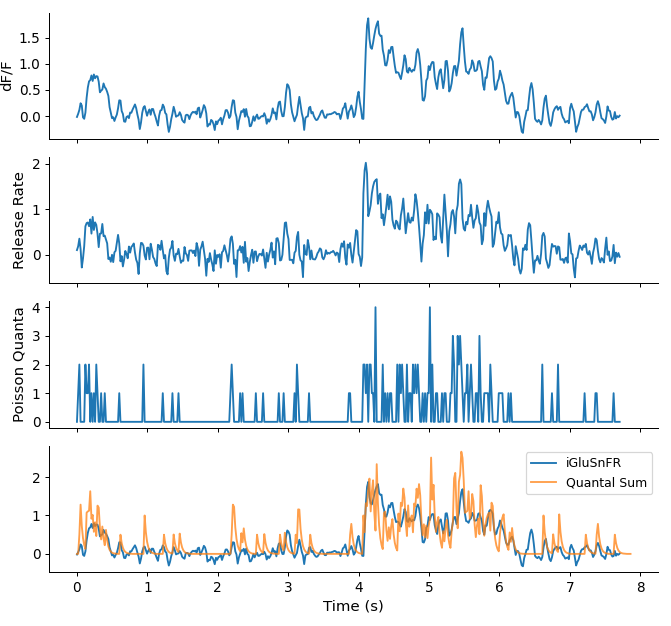

In [23]:
# TODO: GA wants a single trial (single ROI) representative trace. Add another axis
# for the original trace first. so trace -> rate -> quanta -> reconstruction. Also, he'd
# like the quanta generation to be in the old school threshold (not random) way.
depth = "DD"
stim = "snake"
roi_idx = None
#ex = aligned_recs[depth][stim] if roi_idx is None else avg_recs[depth][stim][roi_idx]
#ex = recs[depth][stim][0][1]
ex = pd_examples[2]

xaxis = np.arange(len(ex)) * dt
steady_start = nearest_index(xaxis, 4.74)
steady_stop = nearest_index(xaxis, 5.74)
unique_qse = quantal_size_estimate(ex[steady_start:steady_stop])
#unique_quantum = unique_qse * biexp_quantum
unique_quantum = .5 * biexp_quantum
#unique_quantum = qse_quantum
inv = np.fft.irfft(
    np.fft.rfft(ex) / np.fft.rfft(unique_quantum, n=len(ex))
)


if False:
    bin_t = 0.05  # st
    # bin_t = dt  # s
    sz = int(bin_t / dt)
    bin_edges = np.arange(sz, len(inv) + sz, sz) * dt
    binned = bin_mean(inv, sz)
    scale_mode = False
    ceiling = 0.95
    max_q = 4
    q_scale = 1. / max_q if scale_mode else 1.
    rpq = raster(binned, thresh=np.max(binned) * ceiling / max_q, max_q=max_q)    
    rpq_xaxis = np.arange(len(rpq)) * sz * dt
    rpq_sum = sum_quanta(rpq, bin_edges, unique_quantum * q_scale, dt)
    q_label = "Quanta"
else:
    rpq = poisson_of_release(inv)
    rpq_xaxis = np.arange(len(rpq)) * dt
    rpq_sum = sum_quanta(rpq, np.arange(len(rpq)) * dt, unique_quantum, dt)
    q_label = "Poisson Quanta"

rpq_sum_xaxis = np.arange(len(rpq_sum)) * dt

grant_fig, grant_ax = plt.subplots(4, sharex=True, figsize=(7.5, 7))
grant_ax[0].plot(np.arange(len(ex)) * dt, ex,)
grant_ax[0].set_ylabel("dF/F", fontsize=12)
grant_ax[1].plot(np.arange(len(inv)) * dt, inv)
grant_ax[1].set_ylabel("Release Rate", fontsize=12)
grant_ax[2].plot(rpq_xaxis, rpq)
grant_ax[2].set_ylabel(q_label, fontsize=12)
grant_ax[3].plot(np.arange(len(ex)) * dt, ex, label="iGluSnFR")
grant_ax[3].plot(rpq_sum_xaxis, rpq_sum, alpha=0.75, label="Quantal Sum")
grant_ax[3].legend(fontsize=10)
grant_ax[3].set_xlabel("Time (s)", fontsize=12)
#grant_ax[2].set_xlim(4, 6.5)
clean_axes(grant_ax)
grant_fig.tight_layout()
grant_fig.savefig(os.path.join(data_path, "poisson_quanta_ex.svg"), bbox_inches="tight")
grant_fig.show()